In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

import Neural_network.UNet as unet_implementation
import Data_proccesing.Dataloader as Dataset
import Metrics.Calculations as metrics_functions

d:\dlcourse_ai\.venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Reading config file

In [3]:
import yaml
#Getting path to the config (must be placed into directory with main.py)
with open('./config.yaml', 'r') as file:
    config = yaml.safe_load(file)

### Network architecture

The model of this project is following an architecture of the U Net. Below figure represents this architecture.

**Figure** from *Ronneberger O., Fischer P., Brox T. U-Net: Convolutional Networks for Biomedical Image Segmentation. CoRR, 2015. URL: https://arxiv.org/abs/1505.04597. Ronneberger O., Fischer P., Brox T. U-Net: Convolutional Networks for Biomedical Image Segmentation. CoRR, 2015. URL: https://arxiv.org/abs/1505.04597.*

![UNet architecture](unet_architecture.png)

### Dataset

Dataset for this project [Nails Segmentation Dataset](https://www.kaggle.com/datasets/vpapenko/nails-segmentation)

The original dataset contained color images that were preprocessed.

Augmented versions of color images converted to grayscale were used for training.

This approach allowed the neural network to focus on intensity and texture, ignoring color variations.

The second transformation is designed to augment the dataset by introducing variations in orientation, brightness, contrast, and sharpness

C:\Users\nekry\AppData\Local\Temp\ipykernel_18152\2554707498.py:6: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


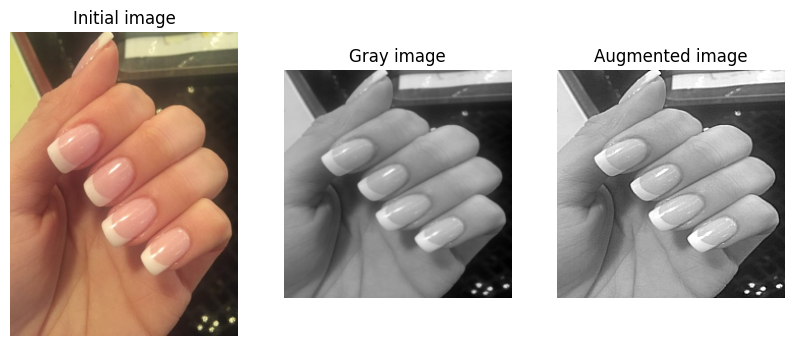

In [4]:
image_path = config['images_path']
image_path = image_path + '1eecab90-1a92-43a7-b952-0204384e1fae.jpg'

trans1 = transforms.Compose([transforms.Grayscale(1), transforms.Resize((224, 224)), transforms.ToTensor()])
trans2 = A.Compose([
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.6),
    A.Sharpen(p=0.6)
])

image = Image.open(image_path)

# Applying the first transformation
image_tensor = trans1(image)

# Converting the tensor back to an image for applying the second transformation
image_np = image_tensor.numpy().transpose(1, 2, 0)  # Changing the axis order for albumentations
image_np = (image_np * 255).astype(np.uint8)

# Applying the second transformation
augmented = trans2(image=image_np)
augmented_image = augmented['image']

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Initial image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
# Original image
plt.title("Gray image")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

# Augmented image
plt.subplot(1, 3, 3)
plt.title("Augmented image")
plt.imshow(augmented_image, cmap='gray')
plt.axis('off')

plt.show()

### Test of the U NET model for nail segmentation

Load the model

In [ ]:
model = unet_implementation.UNet(n_channels = 1, n_classes = 1)  

device = config['device']
checkpoint = torch.load(config['network_config_path'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(config['device'])

Load the dataset

In [ ]:
dataset = Dataset.NailsDataset(config['images_path'], config['labels_path'], trans1 = trans1, trans2 = trans2)

valid_loader = torch.utils.data.DataLoader(dataset, shuffle=True)


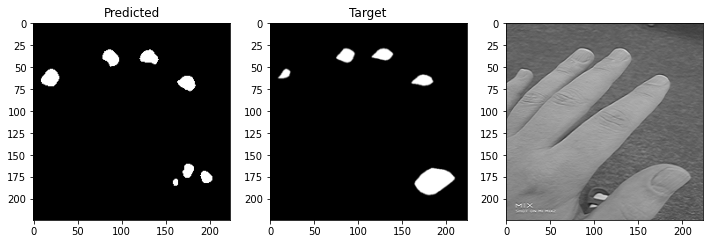

IoU
0.35123309466984887


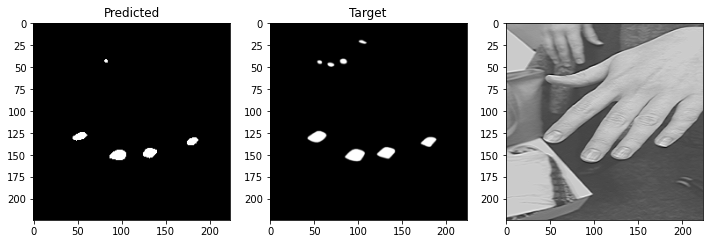

IoU
0.46536412078152756


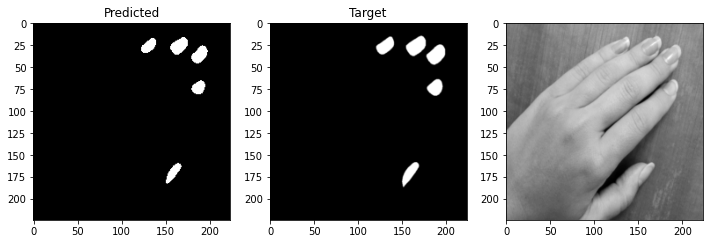

IoU
0.6224899598393574


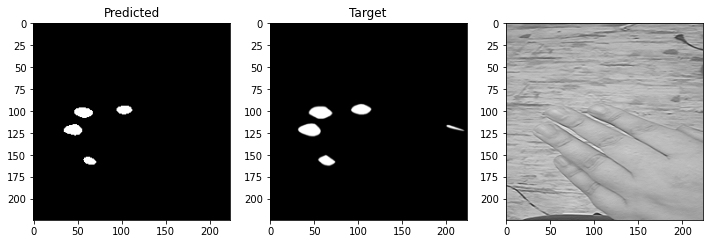

IoU
0.5115131578947368


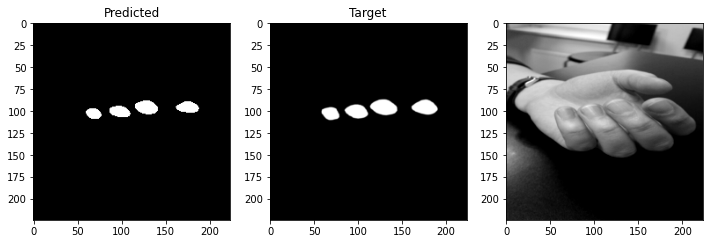

IoU
0.6175548589341693


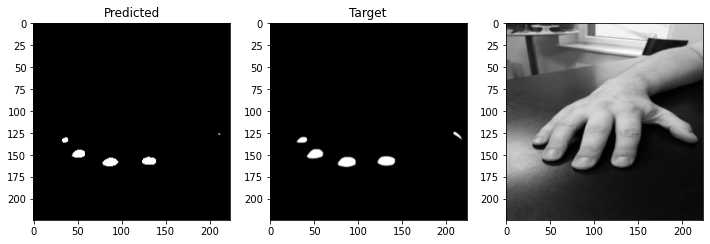

IoU
0.48875


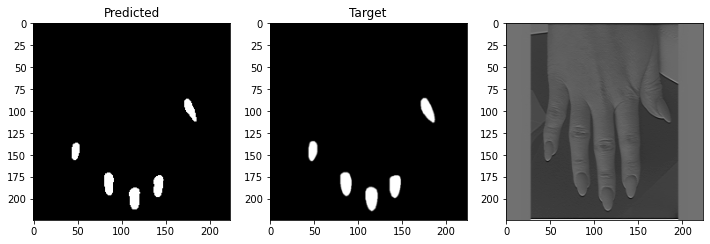

IoU
0.6580246913580247


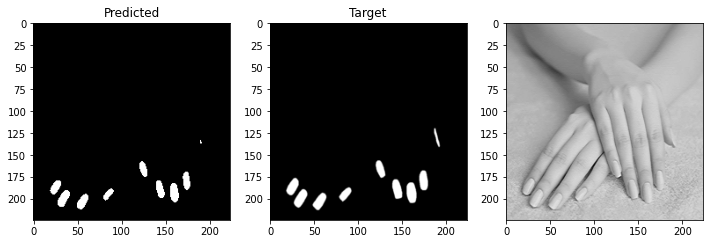

IoU
0.5842992623814541


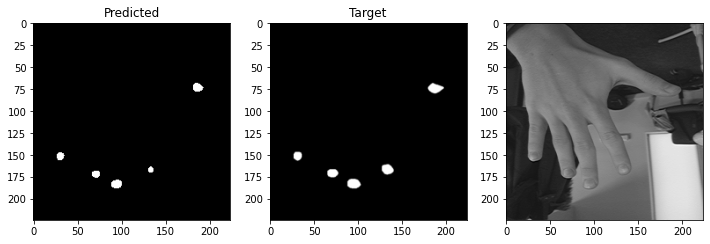

IoU
0.4566929133858268


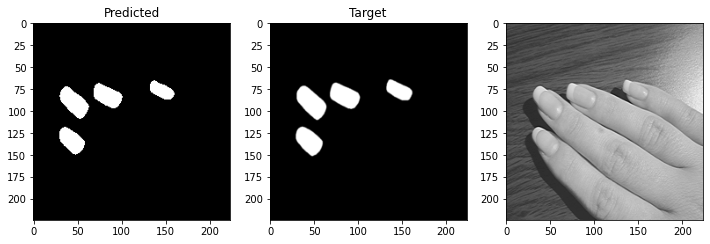

IoU
0.7731888964116452


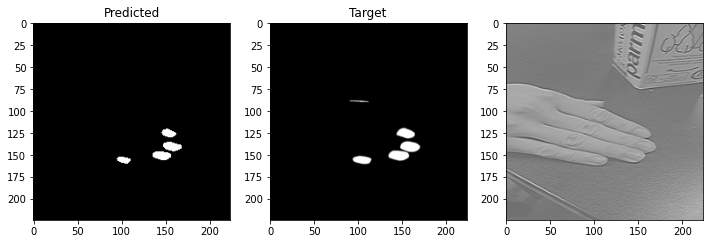

IoU
0.5260570304818093


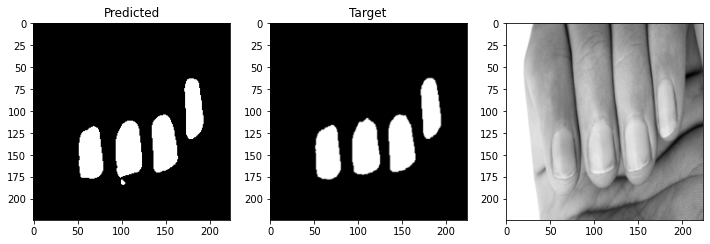

IoU
0.8601334951456311


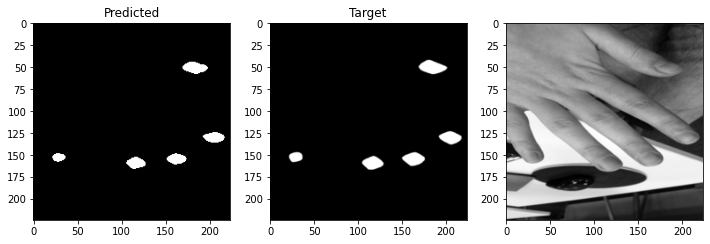

IoU
0.635519801980198


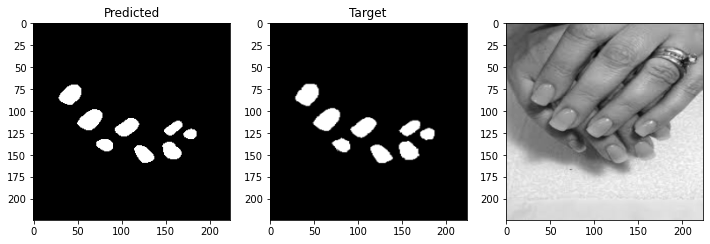

IoU
0.7422369611094363


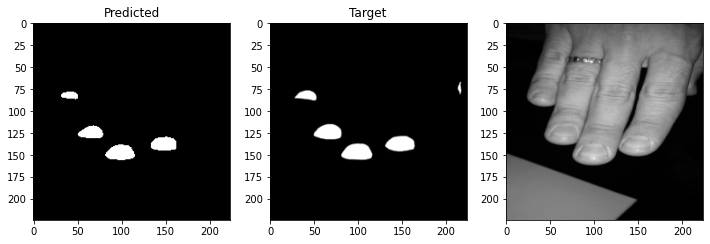

IoU
0.651010101010101


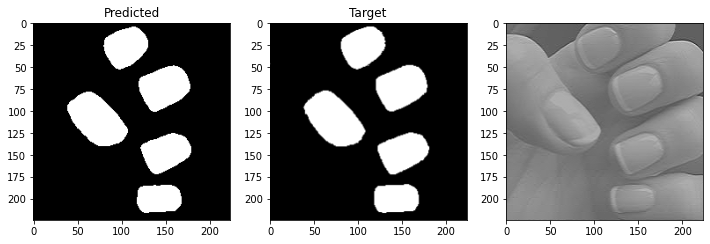

IoU
0.9083386963317092


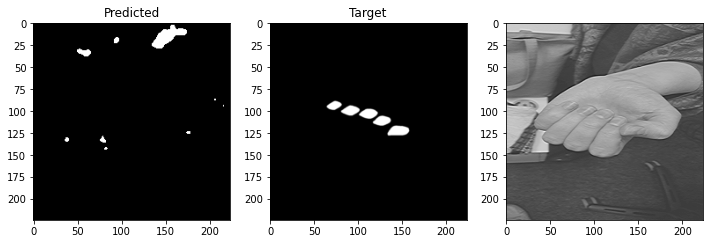

IoU
0.0


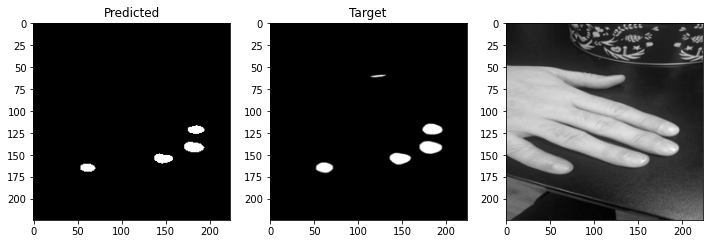

IoU
0.5413223140495868


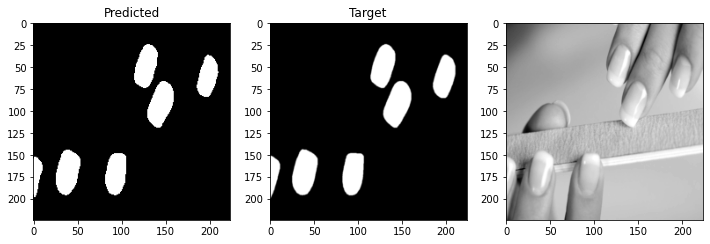

IoU
0.8408203125


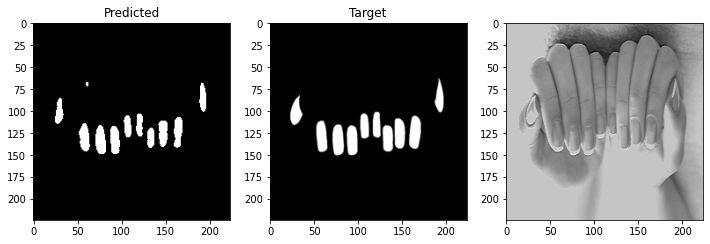

IoU
0.600408788962698


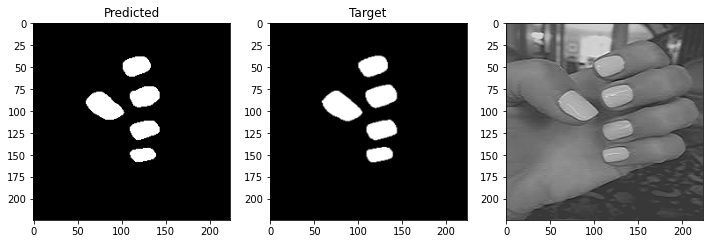

IoU
0.8062700964630225


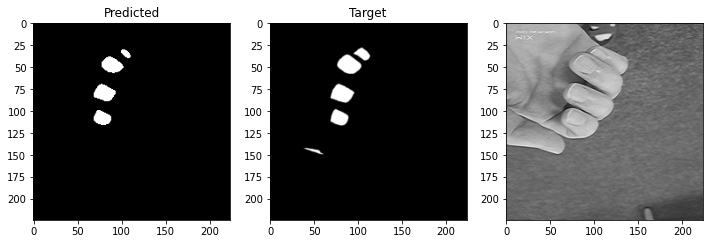

IoU
0.6262755102040817


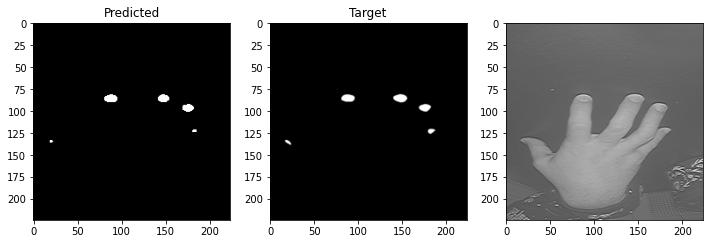

IoU
0.6057142857142858


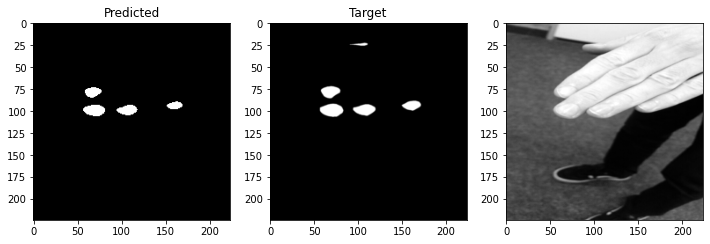

IoU
0.5959514170040486


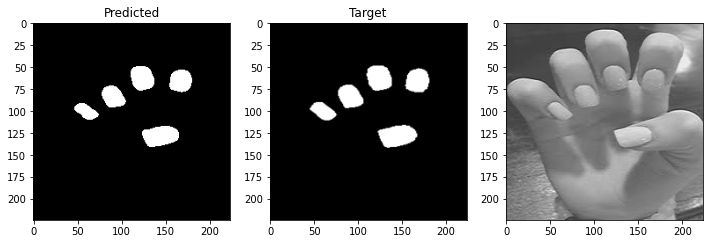

IoU
0.7904707233065442


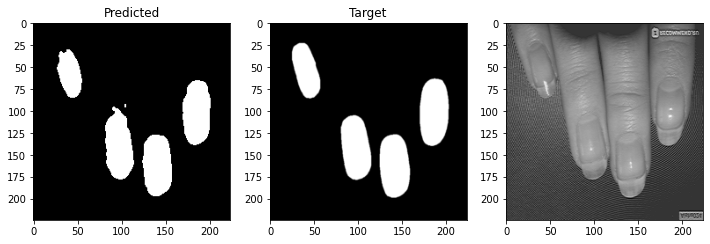

IoU
0.833051461705726


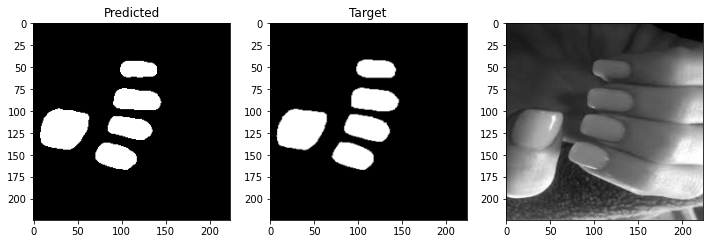

IoU
0.873860629226698


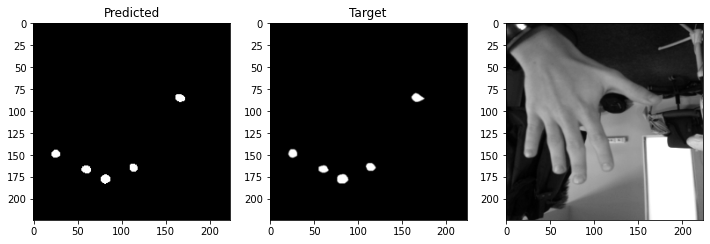

IoU
0.6593220338983051


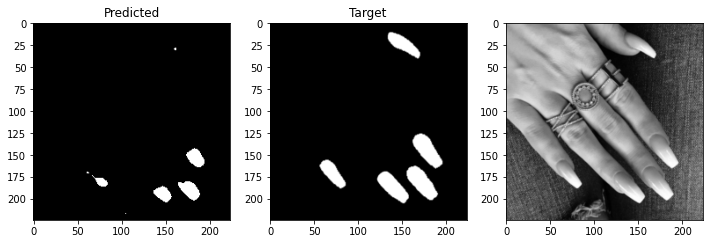

IoU
0.2792590513612125


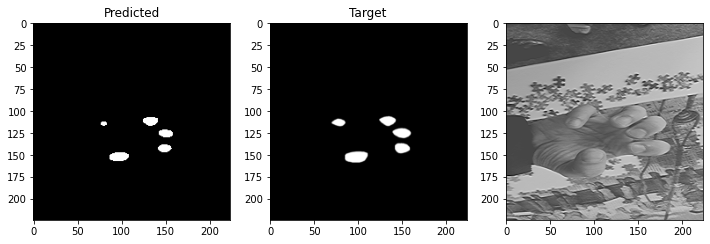

IoU
0.5287671232876713


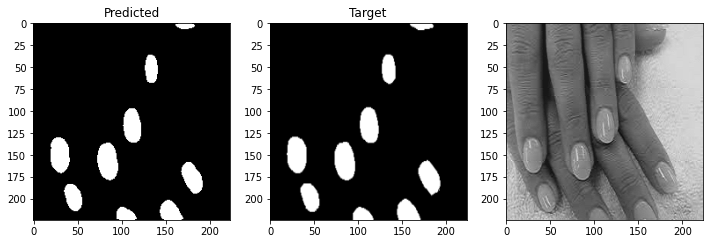

IoU
0.8211306765523633


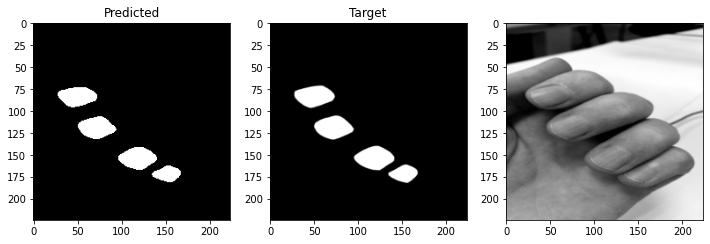

IoU
0.8083867210250437


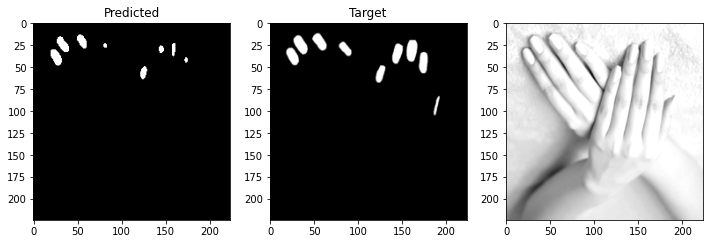

IoU
0.31635651322233105


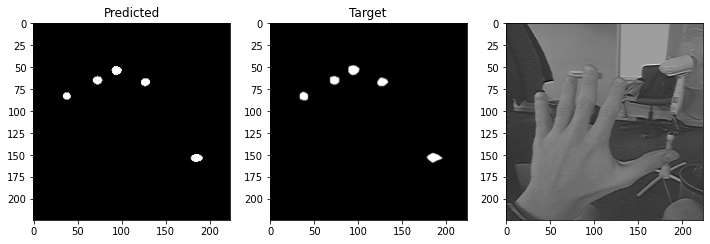

IoU
0.6162246489859594


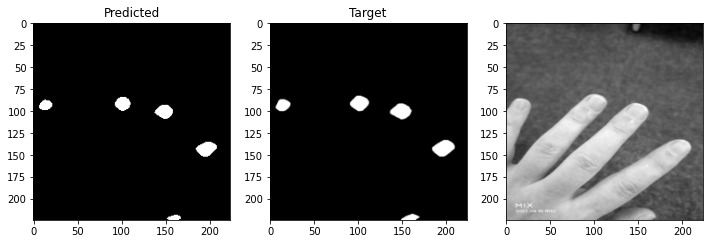

IoU
0.6516620498614959


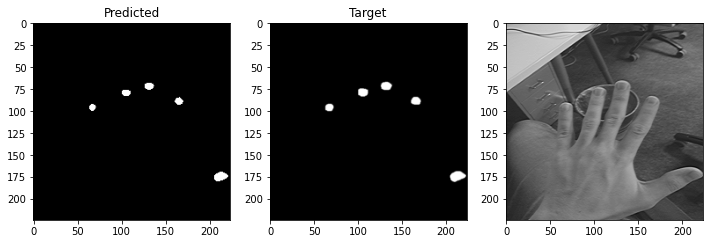

IoU
0.5396113602391629


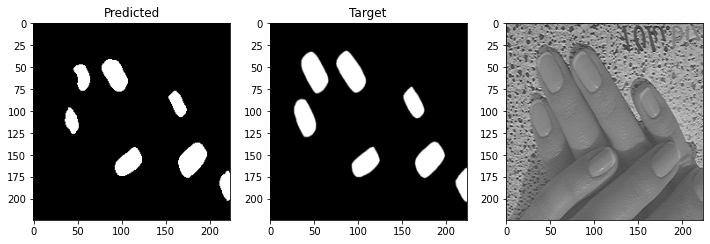

IoU
0.6329712683952348


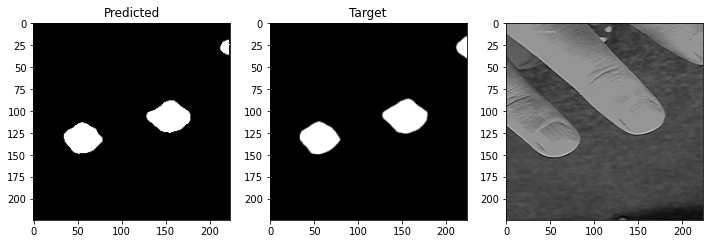

IoU
0.8039408866995074


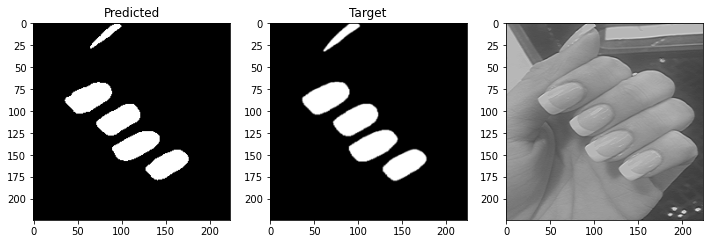

IoU
0.8184784475356346


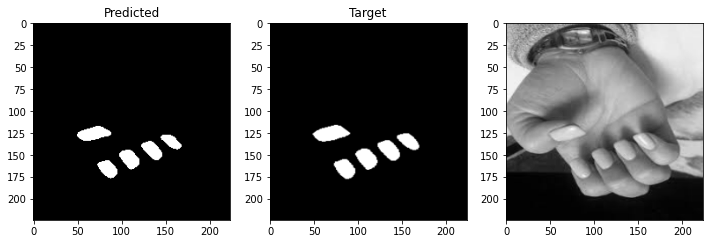

IoU
0.7079948696023942


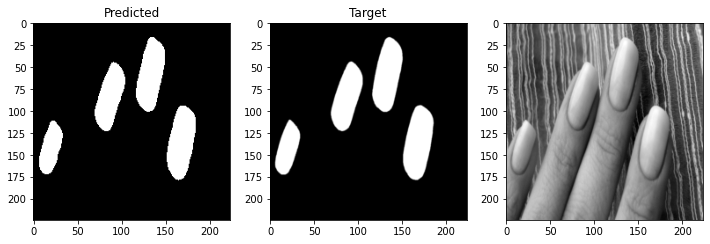

IoU
0.8595877090626215


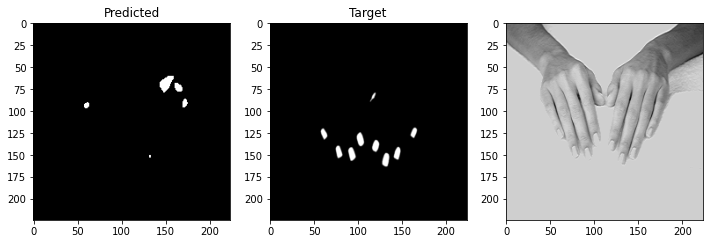

IoU
0.004739336492890996


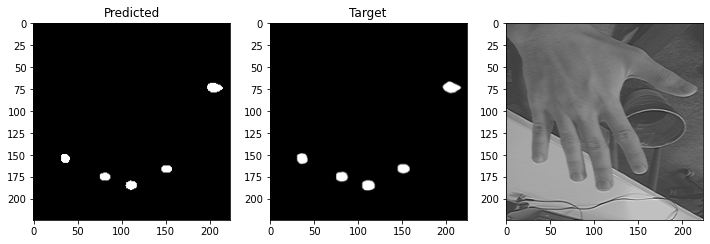

IoU
0.5925925925925926


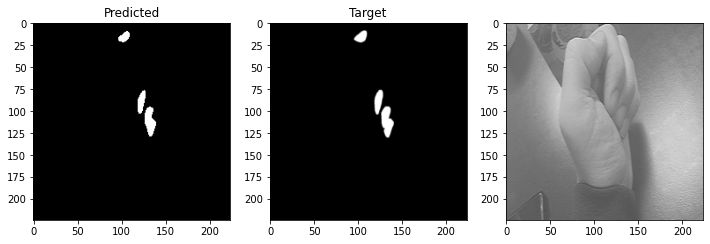

IoU
0.6698224852071006


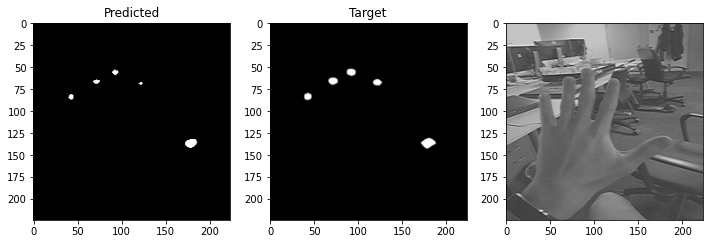

IoU
0.37595419847328243


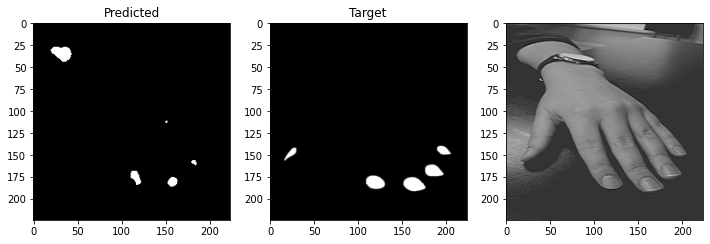

IoU
0.11385199240986717


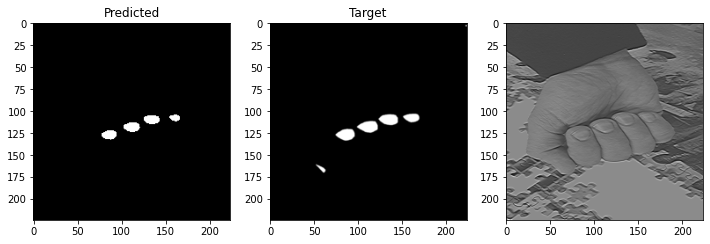

IoU
0.48378127896200185


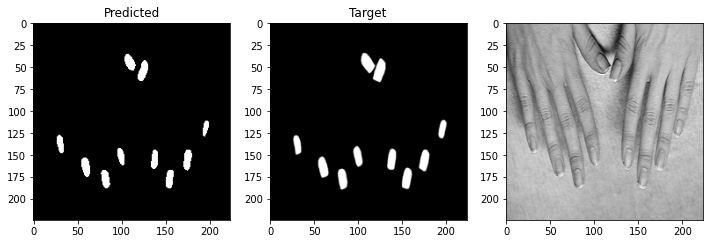

IoU
0.6009693053311793


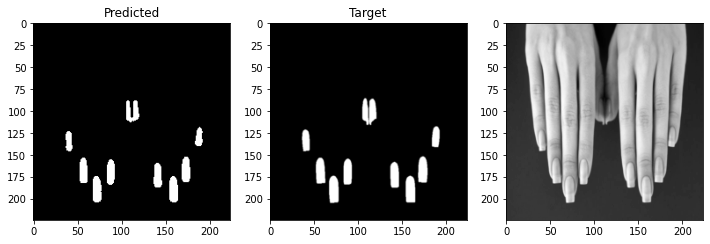

IoU
0.6717760746417861


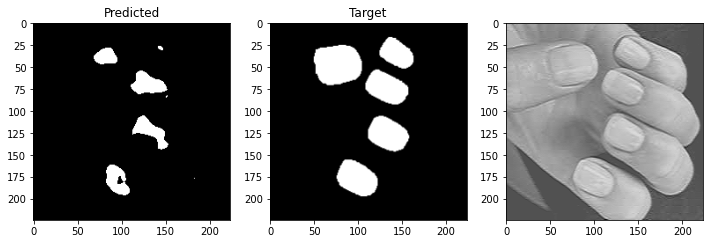

IoU
0.31245064490655433


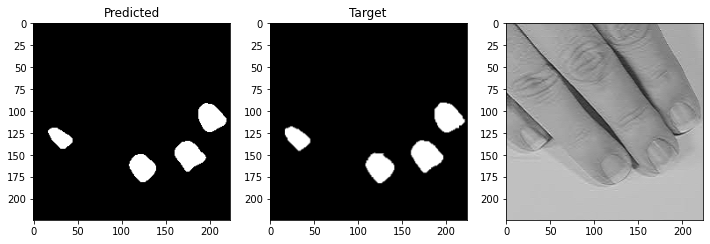

IoU
0.7970970668279407


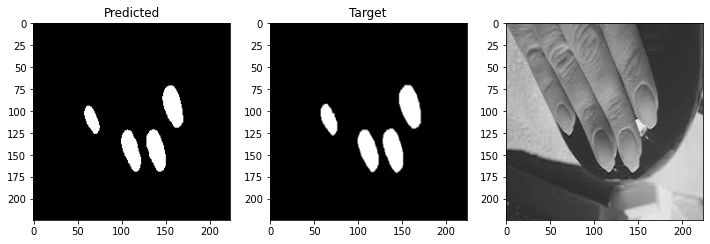

IoU
0.7583952451708766


In [ ]:
for img, mask in valid_loader:
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(metrics_functions.threshold(model((img).to(device))[0][0].cpu().detach().numpy()), cmap = "gray")
    axes[0].set_title("Predicted")
    axes[1].imshow(((mask).to(device))[0][0].cpu().detach().numpy(), cmap = "gray")
    axes[1].set_title("Target")
    axes[2].imshow(((img).to(device))[0][0].cpu().detach().numpy(), cmap = "gray")
    fig.set_figwidth(12)   
    fig.set_figheight(6)  
    plt.savefig('test.png')
    plt.show()
    print("IoU")
    print(metrics_functions.iou(((mask).to(device))[0][0].cpu().detach().numpy(),model((img).to(device))[0][0].cpu().detach().numpy()))
